In [1]:
# Importing needed libraries

import torch, time, os, pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import grad
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from helpers import *

c:\Users\dange\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Impossibile trovare la procedura specificata
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class Generator(nn.Module):
    
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x

In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            # nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

In [4]:
class WGAN(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2):
    
        self.epoch = epoch
        self.batch_size = batch_size
        self.save_dir = save_dir
        self.result_dir = result_dir
        self.device = device
        self.dataset = dataset
        self.input_size = input_size    # Default: 32

        self.model_name = 'WGAN'        
        self.z_dim = 62                 # Dimension of the vector of Gaussian Random Variables
        self.d_param_max = 0.01         # Clipping value
        self.iteration_g_per_d = 5      # The number of iterations of the generator per discriminator iteration


        
        transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                        ])
        
        if self.dataset == 'cifar10':
                self.data_loader = DataLoader(
                    datasets.CIFAR10('data/cifar10', train=True, download=False, transform=transform),
                    batch_size=batch_size, shuffle=True)
        elif self.dataset == 'mnist':
                self.data_loader = DataLoader(
                    datasets.MNIST('data/mnist', train=True, download=False, transform=transform),
                    batch_size=batch_size, shuffle=True)
        

        data = self.data_loader.__iter__().__next__()[0]

        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=lrG, betas=(beta1, beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=lrD, betas=(beta1, beta2))

        if self.device == 'cuda':
            self.G.cuda()
            self.D.cuda()

        # Fixed noise
        self.sample_z = torch.rand((self.batch_size, self.z_dim))
        if self.device == 'cuda':
            self.sample_z = self.sample_z.cuda()

    def train(self):
        self.D_losses = []
        self.G_losses = []
        self.inception_scores = []

        self.y_real = torch.ones(self.batch_size, 1)
        self.y_fake = torch.zeros(self.batch_size, 1)

        if self.device == 'cuda':
            self.y_real = self.y_real.cuda()
            self.y_fake = self.y_fake.cuda()

        self.D.train()

        print('Start training!')

        for epoch in range(self.epoch):
            self.G.train()

            for iter, (x_train, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_noise = torch.rand((self.batch_size, self.z_dim))

                if self.device == 'cuda':
                    x_train = x_train.cuda()
                    z_noise = z_noise.cuda()

                # Training D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_train)
                D_real_loss = -torch.mean(D_real)


                G_ = self.G(z_noise)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(D_fake)

                D_loss = D_real_loss + D_fake_loss

                D_loss.backward()
                self.D_optimizer.step()

                # Clipping D parameters
                for p in self.D.parameters():
                    p.data.clamp_(-self.d_param_max, self.d_param_max)

                if ((iter+1) % self.iteration_g_per_d) == 0:
                    # Update G network
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_noise)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake)

                    self.G_losses.append(G_loss.item())

                    G_loss.backward()

                    self.G_optimizer.step()

                    self.D_losses.append(D_loss.item())
                
                #if (iter % 100) == 0:
                #   self.inception_scores.append(self.calculateInceptionScore())


            
            print(f'Epoch: {epoch}/{self.epoch}')
            print(f'Average Discriminator loss: {np.mean(self.D_losses)}')
            print(f'Average Generator loss: {np.mean(self.G_losses)}\n')

            with torch.no_grad():
                self.visualize_results((epoch+1))

        print("Training finished.")

        #self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.G_losses, self.D_losses, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        is_plot(self.inception_scores)
    
    def calculateInceptionScore(self):
        self.G.eval()
        
        samples = self.G(self.sample_z)
        
        eps=1E-16
        scores=[]
        samples=samples.cpu().data.numpy()
        samples=scale_images(samples, (299,299,3))
        samples=preprocess_input(samples)
        model=InceptionV3()
        p_yx=model.predict(samples)
        p_y = np.expand_dims(p_yx.mean(axis=0), 0)
        kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
        sum_kl_d = kl_d.sum(axis=1)
        avg_kl_d = np.mean(sum_kl_d)
        is_score = np.exp(avg_kl_d)
        scores.append(is_score)
        return scores
        

    def visualize_results(self, epoch):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        samples = self.G(self.sample_z)
        
        if self.device == 'cuda':
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)


        samples = (samples + 1) / 2
        save_images(samples, [8, 8],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')
    
    def print_networks(self):
        print('---------- Networks architecture -------------')
        print(self.G)
        print(self.D)
        print('-----------------------------------------------')


    '''
    def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

    def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))
    '''

In [5]:
class WGAN_GP(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2):
        # parameters
        self.epoch = epoch
        self.dataset = dataset
        self.batch_size = batch_size
        self.save_dir = save_dir
        self.result_dir = result_dir
        self.device = device
        self.input_size = input_size

        self.model_name = 'WGAN_GP'
        self.z_dim = 62
        self.lambda_ = 10
        self.iteration_g_per_d = 5               
        
        transform = transforms.Compose([
                                transforms.Resize((self.input_size, self.input_size)), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                ])

        if self.dataset == 'cifar10':
                self.data_loader = DataLoader(
                    datasets.CIFAR10('data/cifar10', train=True, download=False, transform=transform),
                    batch_size=batch_size, shuffle=True)
        elif self.dataset == 'mnist':
                self.data_loader = DataLoader(
                    datasets.MNIST('data/mnist', train=True, download=False, transform=transform),
                    batch_size=batch_size, shuffle=True)
        
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=lrG, betas=(beta1, beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=lrD, betas=(beta1, beta2))

        if self.device == 'cuda':
            self.G.cuda()
            self.D.cuda()

        # fixed noise
        self.sample_z = torch.rand((self.batch_size, self.z_dim))
        if self.device == 'cuda':
            self.sample_z = self.sample_z.cuda()

    def train(self):
        self.G_losses = []
        self.D_losses = []

        self.y_real = torch.ones(self.batch_size, 1)
        self.y_fake = torch.zeros(self.batch_size, 1)

        if self.device == 'cuda':
            self.y_real = self.y_real.cuda()
            self.y_fake =  self.y_fake.cuda()

        self.D.train()
        print('Start training!')

        for epoch in range(self.epoch):
            self.G.train()

            for iter, (x_train, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_noise = torch.rand((self.batch_size, self.z_dim))
                if self.device == 'cuda':
                    x_train = x_train.cuda()
                    z_noise = z_noise.cuda()

                # Update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_train)
                D_real_loss = -torch.mean(D_real)

                G_ = self.G(z_noise)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(D_fake)

                # Gradient penalty
                alpha = torch.rand((self.batch_size, 1, 1, 1))
                if self.device == 'cuda':
                    alpha = alpha.cuda()

                x_hat = alpha * x_train.data + (1 - alpha) * G_.data
                x_hat.requires_grad = True

                pred_hat = self.D(x_hat)
                if self.device == 'cuda':
                    gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()).cuda(),
                                 create_graph=True, retain_graph=True, only_inputs=True)[0]
                else:
                    gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()),
                                     create_graph=True, retain_graph=True, only_inputs=True)[0]

                gradient_penalty = self.lambda_ * ((gradients.view(gradients.size()[0], -1).norm(2, 1) - 1) ** 2).mean()

                D_loss = D_real_loss + D_fake_loss + gradient_penalty

                D_loss.backward()
                self.D_optimizer.step()

                if ((iter+1) % self.iteration_g_per_d) == 0:
                    # update G network
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_noise)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake)
                    self.G_losses.append(G_loss.item())

                    G_loss.backward()
                    self.G_optimizer.step()

                    self.D_losses.append(D_loss.item())
                
            print(f'Epoch: {epoch+1}/{self.epoch}')
            print(f'Average Discriminator loss: {np.mean(self.D_losses)}')
            print(f'Average Generator loss: {np.mean(self.G_losses)}\n')

            with torch.no_grad():
                self.visualize_results((epoch+1))

        print("Training finished!")

        #self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.G_losses, self.D_losses, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
    
    def calculateInceptionScore(self):
        self.G.eval()

        samples = self.G(self.sample_z)
        
        eps=1E-16
        scores=[]
        samples=samples.cpu().data.numpy()
        samples=scale_images(samples, (299,299,3))
        samples=preprocess_input(samples)
        model=InceptionV3()
        p_yx=model.predict(samples)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        sum_kl_d = kl_d.sum(axis=1)
        avg_kl_d = mean(sum_kl_d)
        is_score = exp(avg_kl_d)
        scores.append(is_score)
        return scores
        
    def visualize_results(self, epoch, fix=True):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        samples = self.G(self.sample_z)
        

        if self.device == 'cuda':
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples, [8, 8],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')

    def print_networks(self):
        print('---------- Networks architecture -------------')
        print(self.G)
        print(self.D)
        print('-----------------------------------------------')

    '''
    def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

    def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))
    '''

In [6]:
# PARAMETERS

# Define dataset
dataset = 'cifar10'

# Define WGAN type (WGAN or WGAN_GP)
gan_type = 'WGAN_GP'

# Define number of epoch
epoch = 100

# Define batch_size
batch_size = 64

# Define input_size
input_size = 32

# Define directory for saving results and models
save_dir = 'models'
result_dir = 'results'

# Defining learning rates
lrG = 0.0002        # Generator
lrD = 0.0002        # Discriminator

# Adam beta parameters
beta1 = 0.5
beta2 = 0.999

# 'cuda' if GPU is available, 'cpu' else
device = 'cuda' if torch.cuda.is_available() else 'cpu'


wgan = WGAN(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)
wgan_gp = WGAN_GP(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)


'''
if gan_type == 'WGAN':
    wgan = WGAN(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)
elif gan_type == 'WGAN_GP':
    wgan = WGAN_GP(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)
'''

"\nif gan_type == 'WGAN':\n    wgan = WGAN(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)\nelif gan_type == 'WGAN_GP':\n    wgan = WGAN_GP(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)\n"

Start training!


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 0/100
Average Discriminator loss: -0.011098136579862628
Average Generator loss: 0.0015107408601183218



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 1/100
Average Discriminator loss: -0.014722234123604348
Average Generator loss: 0.00351348130868409



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 2/100
Average Discriminator loss: -0.016695826017132633
Average Generator loss: 0.004700288977793619



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 3/100
Average Discriminator loss: -0.01800679329887946
Average Generator loss: 0.005479654929424727



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 4/100
Average Discriminator loss: -0.017298596256370775
Average Generator loss: 0.005363426358720365



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 5/100
Average Discriminator loss: -0.0168172687379908
Average Generator loss: 0.005241468795379932



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 6/100
Average Discriminator loss: -0.016230516615106244
Average Generator loss: 0.005060393234122448



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 7/100
Average Discriminator loss: -0.016956282244231822
Average Generator loss: 0.005481995601549454



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 8/100
Average Discriminator loss: -0.01700513089479324
Average Generator loss: 0.005592478818639561



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 9/100
Average Discriminator loss: -0.017583714059377926
Average Generator loss: 0.005932120104224827



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 10/100
Average Discriminator loss: -0.017691633473370237
Average Generator loss: 0.006007468633181801



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 11/100
Average Discriminator loss: -0.017563284612890098
Average Generator loss: 0.005968950780114914



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 12/100
Average Discriminator loss: -0.016961618584864984
Average Generator loss: 0.005757072272497849



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 13/100
Average Discriminator loss: -0.01667006154310755
Average Generator loss: 0.005672841078044407



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 14/100
Average Discriminator loss: -0.016465248487656937
Average Generator loss: 0.005627264481113848



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 15/100
Average Discriminator loss: -0.016463679137767685
Average Generator loss: 0.005654166222574857



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 16/100
Average Discriminator loss: -0.01636389868598548
Average Generator loss: 0.005645452446491944



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 17/100
Average Discriminator loss: -0.01669127816291084
Average Generator loss: 0.005812395362219334



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 18/100
Average Discriminator loss: -0.016441392953098814
Average Generator loss: 0.005724676944320127



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 19/100
Average Discriminator loss: -0.016283851878184718
Average Generator loss: 0.005682771736412225



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 20/100
Average Discriminator loss: -0.01613842884131357
Average Generator loss: 0.005633643678766631



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 21/100
Average Discriminator loss: -0.01630382032153584
Average Generator loss: 0.005712866107516848



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 22/100
Average Discriminator loss: -0.016102038023788574
Average Generator loss: 0.0056491363657704425



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 23/100
Average Discriminator loss: -0.01602627803582343
Average Generator loss: 0.005631512188892495



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 24/100
Average Discriminator loss: -0.01634607560786371
Average Generator loss: 0.005782511109845916



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 25/100
Average Discriminator loss: -0.016586512270679973
Average Generator loss: 0.005905690952814085



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 26/100
Average Discriminator loss: -0.01633751100457643
Average Generator loss: 0.005829317395968426



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 27/100
Average Discriminator loss: -0.016119610237139915
Average Generator loss: 0.005770875556676994



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 28/100
Average Discriminator loss: -0.015868905444273503
Average Generator loss: 0.005621636852598268



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 29/100
Average Discriminator loss: -0.015758831065060305
Average Generator loss: 0.005565742503644381



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 30/100
Average Discriminator loss: -0.01559508755473
Average Generator loss: 0.005485851791730833



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 31/100
Average Discriminator loss: -0.015501282687596474
Average Generator loss: 0.005436995772391548



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 32/100
Average Discriminator loss: -0.01549914094596093
Average Generator loss: 0.005438878085530746



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 33/100
Average Discriminator loss: -0.01578799707399762
Average Generator loss: 0.0055605517080513775



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 34/100
Average Discriminator loss: -0.015687047036153805
Average Generator loss: 0.005497906788775417



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 35/100
Average Discriminator loss: -0.01557049593266077
Average Generator loss: 0.0054181905741881664



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 36/100
Average Discriminator loss: -0.015446227622933502
Average Generator loss: 0.005356359190812044



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 37/100
Average Discriminator loss: -0.015342585137670672
Average Generator loss: 0.005301436505863749



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 38/100
Average Discriminator loss: -0.015249517713563771
Average Generator loss: 0.005247501574509522



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 39/100
Average Discriminator loss: -0.015210576189691403
Average Generator loss: 0.005221236130467169



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 40/100
Average Discriminator loss: -0.015248190504991488
Average Generator loss: 0.0052221295369597786



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 41/100
Average Discriminator loss: -0.015224447662130153
Average Generator loss: 0.005198917136127305



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 42/100
Average Discriminator loss: -0.015459797652813665
Average Generator loss: 0.005287767452509922



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 43/100
Average Discriminator loss: -0.015341955035038601
Average Generator loss: 0.005211296556009267



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 44/100
Average Discriminator loss: -0.015227369294664192
Average Generator loss: 0.005139917367287799



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 45/100
Average Discriminator loss: -0.015113708403755213
Average Generator loss: 0.0050730674232992365



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 46/100
Average Discriminator loss: -0.015029509157782202
Average Generator loss: 0.005020084714230873



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 47/100
Average Discriminator loss: -0.014939023019466816
Average Generator loss: 0.004965473053344702



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 48/100
Average Discriminator loss: -0.014850481719218656
Average Generator loss: 0.004923362614505158



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 49/100
Average Discriminator loss: -0.014770881998847471
Average Generator loss: 0.004874084151685961



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 50/100
Average Discriminator loss: -0.014731988990616611
Average Generator loss: 0.00484383228273258



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 51/100
Average Discriminator loss: -0.014896052461503691
Average Generator loss: 0.004899814337094445



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 52/100
Average Discriminator loss: -0.014778784661836727
Average Generator loss: 0.004831699619971316



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 53/100
Average Discriminator loss: -0.01466667032476617
Average Generator loss: 0.004754010462896319



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 54/100
Average Discriminator loss: -0.014557641834662526
Average Generator loss: 0.0046927449486010055



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 55/100
Average Discriminator loss: -0.01447348963904585
Average Generator loss: 0.004642716147795259



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 56/100
Average Discriminator loss: -0.014398541961604467
Average Generator loss: 0.004604126789655817



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 57/100
Average Discriminator loss: -0.014344923006111458
Average Generator loss: 0.004570679184292884



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 58/100
Average Discriminator loss: -0.01429097911951857
Average Generator loss: 0.004536476902805046



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 59/100
Average Discriminator loss: -0.014222029332900753
Average Generator loss: 0.004507621131868555



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 60/100
Average Discriminator loss: -0.014156710429395595
Average Generator loss: 0.004473999830063453



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 61/100
Average Discriminator loss: -0.014091819374079271
Average Generator loss: 0.0044419952919277665



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 62/100
Average Discriminator loss: -0.01402503004696314
Average Generator loss: 0.004409699888522526



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 63/100
Average Discriminator loss: -0.013959626737731084
Average Generator loss: 0.004378892764313273



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 64/100
Average Discriminator loss: -0.013903448761472845
Average Generator loss: 0.004342688719900981



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 65/100
Average Discriminator loss: -0.01383648655546558
Average Generator loss: 0.004307510919711911



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 66/100
Average Discriminator loss: -0.013770645442357161
Average Generator loss: 0.004273179468018992



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 67/100
Average Discriminator loss: -0.01370380895049072
Average Generator loss: 0.004238869456922255



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 68/100
Average Discriminator loss: -0.013646895150843911
Average Generator loss: 0.004211233280007139



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 69/100
Average Discriminator loss: -0.013682100422496053
Average Generator loss: 0.0042102626165978355



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 70/100
Average Discriminator loss: -0.013601223763499442
Average Generator loss: 0.004168053475505999



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 71/100
Average Discriminator loss: -0.013530122181689103
Average Generator loss: 0.004131021210782573



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 72/100
Average Discriminator loss: -0.013460982480445466
Average Generator loss: 0.004092411942387918



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 73/100
Average Discriminator loss: -0.013394675476273791
Average Generator loss: 0.0040543288251215105



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 74/100
Average Discriminator loss: -0.013330942316547446
Average Generator loss: 0.004022569875548789



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 75/100
Average Discriminator loss: -0.01327362856700568
Average Generator loss: 0.003985287871303684



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 76/100
Average Discriminator loss: -0.013212637971332023
Average Generator loss: 0.003947202609913692



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 77/100
Average Discriminator loss: -0.01315509097337824
Average Generator loss: 0.003909302842010789



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 78/100
Average Discriminator loss: -0.013097603886825092
Average Generator loss: 0.00387751339177396



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 79/100
Average Discriminator loss: -0.013040983001512638
Average Generator loss: 0.0038430456262607874



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 80/100
Average Discriminator loss: -0.012986117887208732
Average Generator loss: 0.0038153758760731816



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 81/100
Average Discriminator loss: -0.012930508897562693
Average Generator loss: 0.0037859498179017006



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 82/100
Average Discriminator loss: -0.012875668887384197
Average Generator loss: 0.0037534764974811075



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 83/100
Average Discriminator loss: -0.012823195764583774
Average Generator loss: 0.0037190488461359625



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 84/100
Average Discriminator loss: -0.012765994161562934
Average Generator loss: 0.0036713587606561605



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 85/100
Average Discriminator loss: -0.012723603812831042
Average Generator loss: 0.0036426935905663708



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 86/100
Average Discriminator loss: -0.012669614786965903
Average Generator loss: 0.0036113428118354743



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 87/100
Average Discriminator loss: -0.012618669473090396
Average Generator loss: 0.0035815977603094232



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 88/100
Average Discriminator loss: -0.012571063618793331
Average Generator loss: 0.0035542523826108674



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 89/100
Average Discriminator loss: -0.012524117697437843
Average Generator loss: 0.0035266098130604306



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 90/100
Average Discriminator loss: -0.012475855996113209
Average Generator loss: 0.0034959754216440752



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 91/100
Average Discriminator loss: -0.01243422014344523
Average Generator loss: 0.0034674793546547924



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 92/100
Average Discriminator loss: -0.012385655852448465
Average Generator loss: 0.0034422728195901303



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 93/100
Average Discriminator loss: -0.012339949355113792
Average Generator loss: 0.00341425560606431



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 94/100
Average Discriminator loss: -0.012296116005920496
Average Generator loss: 0.003390971185447753



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 95/100
Average Discriminator loss: -0.012250948898884641
Average Generator loss: 0.0033595336935103404



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 96/100
Average Discriminator loss: -0.012207567060802622
Average Generator loss: 0.003331793552391965



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 97/100
Average Discriminator loss: -0.0121632979356525
Average Generator loss: 0.0033104489712159095



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 98/100
Average Discriminator loss: -0.012121298489006324
Average Generator loss: 0.003285215883157612



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 99/100
Average Discriminator loss: -0.01207871268620343
Average Generator loss: 0.003259290203062007

Training finished.


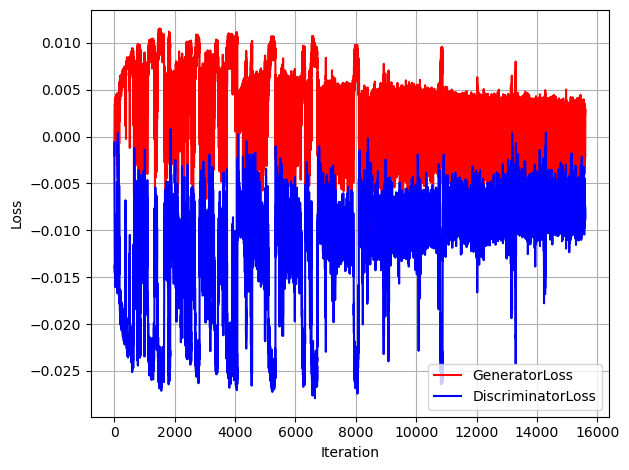

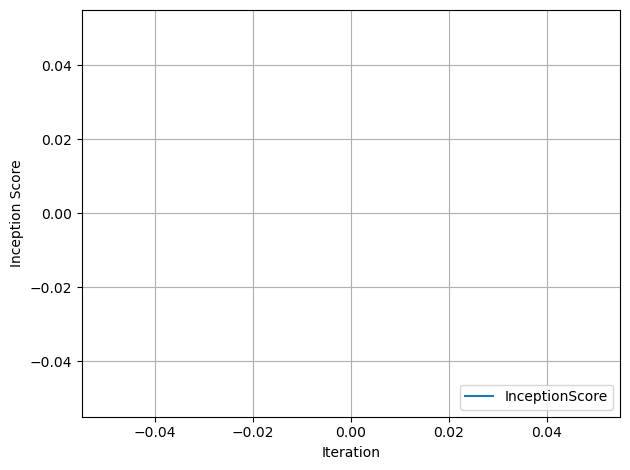

In [7]:
wgan.train()

Start training!


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 1/100
Average Discriminator loss: -0.7010772082930765
Average Generator loss: 0.5857287448568221



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 2/100
Average Discriminator loss: -0.9448247933939385
Average Generator loss: -0.45132551218072575



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 3/100
Average Discriminator loss: -1.0129749499157898
Average Generator loss: 0.07161126760208708



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 4/100
Average Discriminator loss: -1.0673926721941918
Average Generator loss: 1.3963939866337638



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 5/100
Average Discriminator loss: -1.1637330748307972
Average Generator loss: 2.8703375270542426



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 6/100
Average Discriminator loss: -1.267143603762548
Average Generator loss: 4.170784579749164



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 7/100
Average Discriminator loss: -1.3651949865351203
Average Generator loss: 5.3244911055507025



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 8/100
Average Discriminator loss: -1.4596974985324778
Average Generator loss: 6.257130864613618



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 9/100
Average Discriminator loss: -1.5445017906746952
Average Generator loss: 7.056518183379007



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 10/100
Average Discriminator loss: -1.6156038222392686
Average Generator loss: 7.773753977652926



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 11/100
Average Discriminator loss: -1.683343306217464
Average Generator loss: 8.37886664881816



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 12/100
Average Discriminator loss: -1.757466928061281
Average Generator loss: 8.887792894656522



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 13/100
Average Discriminator loss: -1.8216371810168424
Average Generator loss: 9.353406529623788



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 14/100
Average Discriminator loss: -1.882327104771114
Average Generator loss: 9.817862589874274



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 15/100
Average Discriminator loss: -1.9384860678353053
Average Generator loss: 10.230944484058353



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 16/100
Average Discriminator loss: -1.9733082467252807
Average Generator loss: 10.621596548557042



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 17/100
Average Discriminator loss: -2.0118226769793255
Average Generator loss: 10.977992019092111



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 18/100
Average Discriminator loss: -2.013127508527464
Average Generator loss: 11.030627470532501



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 19/100
Average Discriminator loss: -2.051231890986579
Average Generator loss: 11.19948807784561



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 20/100
Average Discriminator loss: -2.0926580587634818
Average Generator loss: 11.419149898675581



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 21/100
Average Discriminator loss: -2.113693666544894
Average Generator loss: 11.611989182680482



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 22/100
Average Discriminator loss: -2.1403434695822505
Average Generator loss: 11.75967654158168



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 23/100
Average Discriminator loss: -2.13716235306631
Average Generator loss: 11.837604263649968



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 24/100
Average Discriminator loss: -2.1530087682230468
Average Generator loss: 11.965866244847799



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 25/100
Average Discriminator loss: -2.1781488208276913
Average Generator loss: 12.098101585671687



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 26/100
Average Discriminator loss: -2.211445088833993
Average Generator loss: 12.226274993377178



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 27/100
Average Discriminator loss: -2.243546519183942
Average Generator loss: 12.348780427644593



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 28/100
Average Discriminator loss: -2.2773260287526864
Average Generator loss: 12.472699966919592



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 29/100
Average Discriminator loss: -2.325494939073917
Average Generator loss: 12.60861930551187



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 30/100
Average Discriminator loss: -2.3783932731952517
Average Generator loss: 12.738693488634421



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 31/100
Average Discriminator loss: -2.382297408362239
Average Generator loss: 12.747421104787572



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 32/100
Average Discriminator loss: -2.3965645267099043
Average Generator loss: 12.788346334214275



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 33/100
Average Discriminator loss: -2.439435932382568
Average Generator loss: 12.844929256705855



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 34/100
Average Discriminator loss: -2.4743261654404036
Average Generator loss: 12.880607844362679



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 35/100
Average Discriminator loss: -2.4479367933154186
Average Generator loss: 12.779207572501985



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 36/100
Average Discriminator loss: -2.4219288802158454
Average Generator loss: 12.525717719558871



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 37/100
Average Discriminator loss: -2.4303229594301774
Average Generator loss: 12.3374495865417



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 38/100
Average Discriminator loss: -2.426619524807027
Average Generator loss: 12.175321536364885



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 39/100
Average Discriminator loss: -2.4149934878321164
Average Generator loss: 12.064917508057178



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 40/100
Average Discriminator loss: -2.43043241257248
Average Generator loss: 11.953077365742184



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 41/100
Average Discriminator loss: -2.460016415920691
Average Generator loss: 11.866503810511205



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 42/100
Average Discriminator loss: -2.4696706521602847
Average Generator loss: 11.750941501848482



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 43/100
Average Discriminator loss: -2.461953682448164
Average Generator loss: 11.641997611957626



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 44/100
Average Discriminator loss: -2.4729141911667054
Average Generator loss: 11.591217114043038



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 45/100
Average Discriminator loss: -2.4841633462325863
Average Generator loss: 11.546976062525966



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 46/100
Average Discriminator loss: -2.500922858025391
Average Generator loss: 11.49874873492356



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 47/100
Average Discriminator loss: -2.520283731394404
Average Generator loss: 11.435147127993222



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 48/100
Average Discriminator loss: -2.508156583668081
Average Generator loss: 11.333574923453853



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 49/100
Average Discriminator loss: -2.50751217170426
Average Generator loss: 11.227293597057672



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 50/100
Average Discriminator loss: -2.490176006540035
Average Generator loss: 11.058760292841455



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 51/100
Average Discriminator loss: -2.4819343754314187
Average Generator loss: 10.935498498719188



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 52/100
Average Discriminator loss: -2.4977016694422653
Average Generator loss: 10.831436804021825



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 53/100
Average Discriminator loss: -2.50674457489398
Average Generator loss: 10.698703723809587



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 54/100
Average Discriminator loss: -2.52456340745975
Average Generator loss: 10.560629410923928



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 55/100
Average Discriminator loss: -2.5439352406416793
Average Generator loss: 10.428620277532747



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 56/100
Average Discriminator loss: -2.5530060675750392
Average Generator loss: 10.294495462112456



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 57/100
Average Discriminator loss: -2.572807778240891
Average Generator loss: 10.144872419184196



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 58/100
Average Discriminator loss: -2.588829464722749
Average Generator loss: 9.997187534187427



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 59/100
Average Discriminator loss: -2.6122387348567386
Average Generator loss: 9.839670943165087



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 60/100
Average Discriminator loss: -2.620301930784471
Average Generator loss: 9.677396228954068



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 61/100
Average Discriminator loss: -2.629946951251931
Average Generator loss: 9.506142563914342



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 62/100
Average Discriminator loss: -2.6062370320738544
Average Generator loss: 9.338742261251005



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 63/100
Average Discriminator loss: -2.6031491485099116
Average Generator loss: 9.187475329898767



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 64/100
Average Discriminator loss: -2.6065638717202373
Average Generator loss: 9.015550580680914



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 65/100
Average Discriminator loss: -2.614242595904259
Average Generator loss: 8.821964496408665



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 66/100
Average Discriminator loss: -2.6314690629135753
Average Generator loss: 8.621091387256337



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 67/100
Average Discriminator loss: -2.638330973151407
Average Generator loss: 8.420942736113814



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 68/100
Average Discriminator loss: -2.6424608806520067
Average Generator loss: 8.212536028550508



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 69/100
Average Discriminator loss: -2.661587678671087
Average Generator loss: 8.01625263975502



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 70/100
Average Discriminator loss: -2.662543143135335
Average Generator loss: 7.819732338254896



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 71/100
Average Discriminator loss: -2.6450104796446716
Average Generator loss: 7.585026983621723



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 72/100
Average Discriminator loss: -2.6201071966652747
Average Generator loss: 7.356822422129152



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 73/100
Average Discriminator loss: -2.613906632990926
Average Generator loss: 7.172322345545569



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 74/100
Average Discriminator loss: -2.6005813556986945
Average Generator loss: 7.009508306853091



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 75/100
Average Discriminator loss: -2.5986924057904406
Average Generator loss: 6.849423617541663



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 76/100
Average Discriminator loss: -2.6039391742545077
Average Generator loss: 6.699381062506438



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 77/100
Average Discriminator loss: -2.606712005147819
Average Generator loss: 6.54587565114783



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 78/100
Average Discriminator loss: -2.6072313524279034
Average Generator loss: 6.380045252457815



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 79/100
Average Discriminator loss: -2.6077713003826135
Average Generator loss: 6.221926882993025



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 80/100
Average Discriminator loss: -2.6175215992084047
Average Generator loss: 6.062725158894841



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 81/100
Average Discriminator loss: -2.6261177335054464
Average Generator loss: 5.908364595906663



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 82/100
Average Discriminator loss: -2.640660713592619
Average Generator loss: 5.763627312196217



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 83/100
Average Discriminator loss: -2.638498780302212
Average Generator loss: 5.61381472390724



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 84/100
Average Discriminator loss: -2.6367109973182314
Average Generator loss: 5.455939077922872



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 85/100
Average Discriminator loss: -2.648233001163232
Average Generator loss: 5.277965290513491



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 86/100
Average Discriminator loss: -2.664832495488243
Average Generator loss: 5.096258389750206



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 87/100
Average Discriminator loss: -2.679873933084995
Average Generator loss: 4.915914606527505



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 88/100
Average Discriminator loss: -2.6965239725957866
Average Generator loss: 4.723841819173542



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 89/100
Average Discriminator loss: -2.7092225632162883
Average Generator loss: 4.534461826420365



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 90/100
Average Discriminator loss: -2.707668682402053
Average Generator loss: 4.345191032084453



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 91/100
Average Discriminator loss: -2.707929853911368
Average Generator loss: 4.164925972250637



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 92/100
Average Discriminator loss: -2.716060654790641
Average Generator loss: 3.990719452051294



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 93/100
Average Discriminator loss: -2.7069424076006072
Average Generator loss: 3.812173508368032



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 94/100
Average Discriminator loss: -2.716593757348869
Average Generator loss: 3.63341035965761



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 95/100
Average Discriminator loss: -2.731733154641105
Average Generator loss: 3.4457300417492225



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 96/100
Average Discriminator loss: -2.748797928369042
Average Generator loss: 3.2575874689993305



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 97/100
Average Discriminator loss: -2.746127637737745
Average Generator loss: 3.0579030560711145



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 98/100
Average Discriminator loss: -2.7421685739247104
Average Generator loss: 2.8630231458246356



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 99/100
Average Discriminator loss: -2.7462655030203247
Average Generator loss: 2.676478094246448



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 100/100
Average Discriminator loss: -2.7353954878314517
Average Generator loss: 2.4702385855021958

Training finished!


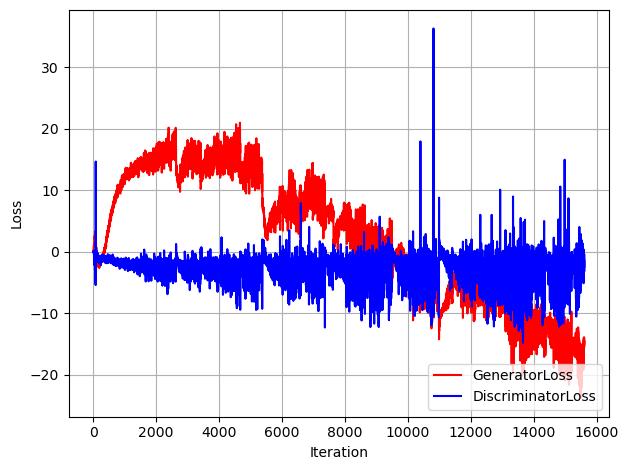

In [8]:
wgan_gp.train()